# Acident tweets search (NLP)

### Problem and data

We should find most like to acident description (or with semantic closer to acident). Lets look on the data. 
* *keywords* Selected automatically keywords
* *location* Location selected by tweet. May be useful for short list of acident tweets united by location. But most of is a trash or cutted info
* *text* the most important. contains text. Also catching up with #hashtags and @mentions. MAy it be good to divide in separated columns


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from functools import reduce
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


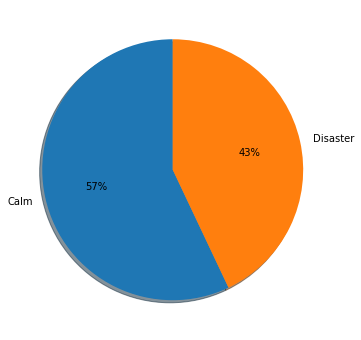

In [117]:
df = pd.read_csv("train.csv")
df.info()
calm, disaster = df["target"].value_counts()
plt.figure(figsize=(12, 6))
plt.pie([calm,disaster], labels=["Calm", "Disaster"], startangle=90, autopct="%0.0f%%", shadow=True)
plt.show()

1) Delete ID

In [118]:
df = df.drop("id", axis=1)

In [119]:
df 

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,NaN,NaN,Police investigating after an e-bike collided ...,1


Lets look on null columns. Keywords are almost all not-null. locations are not defined for in the third cases.

In [120]:
print("Count null \n")
print(df.isnull().sum())
print(f"\nOverall length: {df.__len__()} samples")

Count null 

keyword       61
location    2533
text           0
target         0
dtype: int64

Overall length: 7613 samples


Count keywords. See that keywords alone are not effective at all as they equally belong to ac and non acident texts

In [121]:
print(f"In dataset used {set(df['keyword']).__len__()} keywords")
print(f"Acident: {set(df[df['target']==1]['keyword']).__len__()} keywords")
print(f"Non acident: {set(df[df['target']==0]['keyword']).__len__()} keywords")
kws_ac = set(df[df['target']==1]['keyword'])
kws_nonac = set(df[df['target']==0]['keyword'])
print(f"Keywords that are unique only for acidents: {kws_ac-kws_nonac}")
print(f"Keywords that are unique only for non-acidents: {kws_nonac-kws_ac}, which is seems to be negative at all")

In dataset used 222 keywords
Acident: 221 keywords
Non acident: 219 keywords
Keywords that are unique only for acidents: {'derailment', 'debris', 'wreckage'}
Keywords that are unique only for non-acidents: {'aftershock'}, which is seems to be negative at all


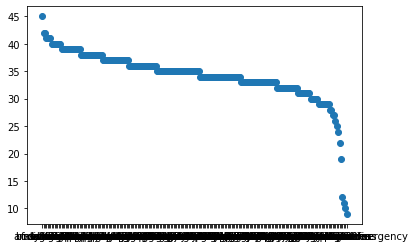

the most common is fatalities : 45
Distribution of targets for keyword 'fatalities': 


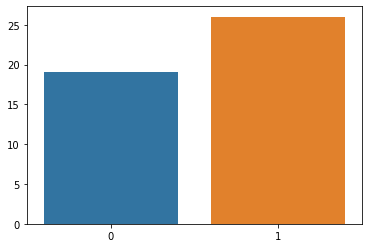

In [122]:
vck = df["keyword"].value_counts()
plt.scatter(x=vck.keys(), y=vck.values)
plt.show()
mck = df["keyword"].value_counts(sort=True)
print("the most common is " + mck.keys()[0] + " : " + str(mck[0]))
tmckd = df[df["keyword"] == "fatalities"]["target"].value_counts()
print("Distribution of targets for keyword 'fatalities': ")
sns.barplot(x=tmckd.keys(), y=tmckd.values)
plt.show()

### Analyzis of texts

We immediately see that hashtags are preceived in messages. Lets divide it to another column. Before we show some examples 

In [123]:
keywords_set = list(set(df[df["keyword"].notna()]["keyword"].values))
keywords_set = list(map(lambda x: x.replace("%20", " "), keywords_set))
location_set = list(set(df[df["location"].notna()]["location"].values))
print("Keywords: "+", ".join(keywords_set[:10]))
print("Locations: "+", ".join(location_set[:10]))

Keywords: demolition, evacuate, avalanche, drowning, wounded, danger, exploded, arsonist, sirens, burning buildings
Locations: Liberty Lake, WA, Predjama, Eslovenia., Austin, ???????, Texas, Kwara, Nigeria, @potteratthedisc, Fort Walton Beach, Fl, Newcastle upon Tyne, Beautiful British Columbia, Decatur, GA


In [124]:
def hashtag_select(s:str):
    p:list = s.split(" ")
    hashtags = filter(lambda x: x.startswith("#"), p)
    cleaned_message = filter(lambda x: not x.startswith("#"), p)
    return (" ".join(list(set(hashtags))), " ".join(cleaned_message))
df["hashtags"] = df["text"].apply(lambda x: hashtag_select(x)[0] if len(hashtag_select(x)[0])!=0 else np.nan)
df["text"] =     df["text"].map(lambda x: hashtag_select(x)[1])

In [125]:
df[df["location"].notnull()&df["keyword"].notnull()]

,keyword,location,text,target,hashtags
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,NaN
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. http://t.co/...,0,#metal #RT
33,ablaze,AFRICA,Breaking news:Nigeria flag set ablaze in Aba. ...,1,#AFRICANBAZE:
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,NaN
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,NaN
...,...,...,...,...,...
7575,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,NaN
7577,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,#whoops
7579,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,NaN
7580,wrecked,London,Cramer: Iger's 3 words that wrecked Disney's s...,0,#forex #trading #FX


And exclude mentions starting with @

In [126]:
def mention_select(s:str):
    p:list = s.split(" ")
    mentions = filter(lambda x: x.startswith("@"), p)
    cleaned_message = filter(lambda x: not x.startswith("@"), p)
    return (" ".join(list(set(mentions))), " ".join(cleaned_message))
df["mentions"] = df["text"].apply(lambda x: mention_select(x)[0] if len(mention_select(x)[0])!=0 else np.nan)
df["text"] =     df["text"].map(lambda x: mention_select(x)[1])
df[df["mentions"].notnull()].head()

,keyword,location,text,target,hashtags,mentions
31,ablaze,Birmingham,Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,NaN,@bbcmtd
36,ablaze,Pretoria,they've built so much hype around new acquisit...,0,#mufc,@PhDSquares
43,ablaze,NaN,SOOOO PUMPED FOR ABLAZE ????,0,NaN,@southridgelife
57,ablaze,"Sao Paulo, Brazil",Set our hearts ablaze and every city was a gif...,0,NaN,@Û_
63,ablaze,"Concord, CA",Steve these fires out here are something else!...,1,NaN,@Navista7 @News24680


Lets move to the text. Lets see some examples to get up with ideas of enchancing text

In [127]:
print(df["text"][354])
print(df["text"][378])
print(df["text"][394])
print(df["text"][221])

Salvation Army hosts rally to reconnect fathers with children: The Salvation Army is hosting a back to school rallyÛ_ http://t.co/rDjpor3AZg
One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army http://t.co/eNCmhz6y34 x1434
Palestinian Teen Killed Amid Protests Against Arson Attack http://t.co/okVsImoGic
BOOM! Your country was just entirely annihilated by a hÛ_ ÛÓ Britain https://t.co/IrFCn71sZv


First thing we should do is to remove all websites. Most of that refer to t.co, which is shortened path to telegram and should be removede

In [128]:
def exclude_sites(x):
    rs = x.split(" ")
    sites = filter(lambda c: c.find("http")!=-1, rs)
    messages = filter(lambda c: c.find("http")==-1, rs)
    return (sites, " ".join(list(messages)))
df["text"] = df["text"].map(lambda x: exclude_sites(x)[1])
df

,keyword,location,text,target,hashtags,mentions
0,NaN,NaN,Our Deeds are the Reason of this May ALLAH For...,1,#earthquake,NaN
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,NaN
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,NaN
3,NaN,NaN,"13,000 people receive evacuation orders in Cal...",1,#wildfires,NaN
4,NaN,NaN,Just got sent this photo from Ruby as smoke fr...,1,#wildfires #Alaska,NaN
...,...,...,...,...,...,...
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,NaN,NaN
7609,NaN,NaN,The out of control wild fires in California ev...,1,NaN,@TheTawniest @aria_ahrary
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1,NaN,NaN
7611,NaN,NaN,Police investigating after an e-bike collided ...,1,NaN,NaN


#### Punctuation

Delete punction and \n. I think we can exclude in further !, as I think it could be high impacted mark.

In [129]:
df["text"] = df["text"].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation+"\n")))


Lets find other improvements 

In [130]:
import random

for i in range(20):
    print(df["text"][random.randint(0, 7000)])

 Who had a car crashsterlingWho was driving in the carMel or JoeySterling Knight
70 Years After Atomic Bombs Japan Still Struggles With War Past The anniversary of the devastation wrought b
Anti Collision Rear
17 dead as Afghanistan aircraft crashes An Afghan military helicopter has crashed in a remote region of the s 
If you looking for my niggas you can follow the sirens 
AKILAH WORLD NEWS Cop pulls man from car to avoid this 
Avalanche City  Sunset
Do you know anyone looking to move to Hammond OR Share this listing
Listening to Blowers and Tuffers on the Aussie batting collapse at Trent Bridge reminds me why I love Wonderful stuff
FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps 
When high fashion and food collide Gucci has chosen one of ShanghaiÛªs most popular commercial avenue
Damn greinke got blown up in that first inning
only had a car for not even a week and got in a fucking car accident  Mfs cant fucking drive 
Were in our Toronto branch Surety Und

1) We should transform to low chars, lemmatize and turn to first normal form and it can be predicted
\
*For further development:
2) divide date in separated column? (some accidents from news use date, may be it could be useful)
3) delete any number, no informations even in combinations if we decide either it is acident or no

Also we should not drop out idea that twits could be connected by one acident


#### Vectorization

In [131]:
model_en = spacy.load("en_core_web_sm")

In [132]:
doc = model_en(df["text"].loc[789])
x = doc[1]
print(x)
print(x.left_edge) # left related token
print(x.right_edge) # left related token
print(x.ent_iob_)
print(x.lemma_)
print(x.morph)
print(x.pos_)
print(x.lang_)
doc

wanted
so
got
O
want
Tense=Past|VerbForm=Fin
VERB
en


so wanted to see that info on blight u got

In [133]:
from spacy import displacy
displacy.render(model_en(df["text"].loc[2354]), style="dep")

Delete stop words from the text by english default stop words list spacy. Filtered words are automatically lemmatized and replce old values in-place. Our texts are fully ready for learning!

In [134]:
tex = model_en(df["text"].loc[4345])
ltokens = [i.lemma_.lower() for i in list(tex) if not i.__str__().lower() in model_en.Defaults.stop_words]
print(ltokens)

df["text"] = df["text"].map(lambda x: [i.lemma_.lower() for i in list(model_en(x)) if not i.__str__().lower() in model_en.Defaults.stop_words])

['tension', 'bayelsa', 'patience', 'jonathan', 'plan', 'hijack', 'apc', 'pdp']


In the advance say we could unit named entities to token!

In [135]:
df.head()

,keyword,location,text,target,hashtags,mentions
0,NaN,NaN,"[deed, reason, allah, forgive]",1,#earthquake,NaN
1,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1,NaN,NaN
2,NaN,NaN,"[resident, ask, shelter, place, notify, office...",1,NaN,NaN
3,NaN,NaN,"[13000, people, receive, evacuation, order, ca...",1,#wildfires,NaN
4,NaN,NaN,"[got, send, photo, ruby, smoke, pour, school]",1,#wildfires #Alaska,NaN


### Learning

##### *Vectorization*

Lets use vector -> [frequency_disaster,frequency_calm]. Collect info and get prediction

In [145]:
count_dict = {}
for index in range(df.__len__()):
    txt = df["text"].loc[index]
    tg = df["target"].loc[index]
    for token in txt:
        if (token not in count_dict):
            count_dict[token] = [tg, int(not tg), 1]
        else:
            v = count_dict[token]
            count_dict[token] = [v[0]+tg, v[1]+(not tg), v[2]+1]
print(list(count_dict.values())[34])
    

[14, 14, 28]


Lets transform our texts to vector. 
I tried to create vectors (calm count, acident count), but the max probability was 75%.
Better to append observable feature - precisioin of world , and change counts to probability. Then our accuracy has increased to 93%

In [146]:
X = []
y = []
for i in range(len(df)):
    svec = [1, 0, 0, 0]
    y.append(df["target"].loc[i])
    for j in df["text"].loc[i]:
        svec[1] += count_dict[j][0]/count_dict[j][2]
        svec[2] += count_dict[j][1]/count_dict[j][2]
        svec[3] += svec[1]-svec[2]
    X.append(svec)

In [141]:
print(X[:5])
print(y[:5])

[[1, 2.1666666666666665, 1.8333333333333335, 0.39999999999999947], [1, 5.93001893939394, 1.0699810606060605, 18.779356060606062], [1, 8.095666785206259, 2.9043332147937404, 32.3500127006706], [1, 4.9426503759398495, 1.0573496240601505, 13.714172932330825], [1, 3.412806627384113, 3.5871933726158876, -2.9615804594803663]]
[1, 1, 1, 1, 1]


#### *Splitting*

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2 )

Let learn SVM model on our vecotors-sentences

In [148]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [149]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       874
           1       0.95      0.87      0.91       649

    accuracy                           0.92      1523
   macro avg       0.93      0.92      0.92      1523
weighted avg       0.93      0.92      0.92      1523



Now lets tune our parameters. Try differnet penlty coefficients, and we get in the result C=2 as the ideal coefficient for RBF kernel

In [150]:
scores = []
for i in range(1, 10):
    clf = svm.SVC(kernel="rbf", C=0.5*i)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

<AxesSubplot:>

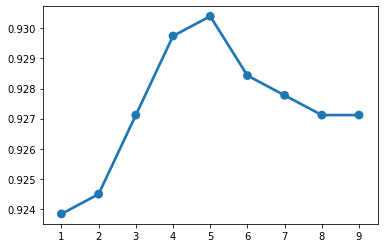

In [151]:
sns.pointplot(x=list(range(1, 10)), y=scores)

In [152]:
svm_clf = svm.SVC(kernel="rbf", C=2)
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.9297439264609324

SVM with ploynomial works worse: about 67% accuracy

In [35]:
clf = svm.SVC(kernel="poly", C=1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6736703873933026

Lets try logistic regression

In [153]:
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
print(f"Logistic regression score {round(log_clf.score(X_test, y_test) * 100, 2)} percent")

Logistic regression score 92.45 percent


Lets try Naive Bayes. Its value lower on test data

In [154]:
from sklearn.naive_bayes import GaussianNB
gs_clf = GaussianNB()
gs_clf.fit(X_train, y_train)
print(f"Bayes score {round(gs_clf.score(X_test, y_test) * 100, 2)} percent")


Bayes score 92.19 percent


Lets try trees 

In [155]:
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)
print(f"Tree score {round(tree_clf.score(X_test, y_test) * 100, 2)} percent")

Tree score 91.07 percent


<AxesSubplot:>

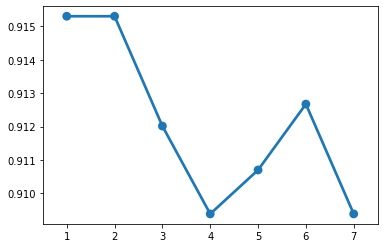

In [156]:
score = []
for i in range(1, 8):
    tree_clf = DecisionTreeClassifier(max_depth=i)
    tree_clf.fit(X_train, y_train)
    score.append(tree_clf.score(X_test, y_test))
sns.pointplot(x=list(range(1, 8)), y=score)

But logically I think better to take 4 tree

In [157]:
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X_train, y_train)
print(tree_clf.score(X_test, y_test))

0.9093893630991464


And finally we have such models

|  Model |  Score |
|---|---|
|  SVM | 79%  | 
|  Log | 79%  | 
|  Bayes | 64%  |  
|  Trees | 75%  |  

### Final result of task

Lets create algorythm which helps to filtrate texts in the tweet. We have the database of words-markers in the variable <count_dict> with pairs {word - vector}. Also we have rules for creating cleaned text. And finally we will apply models.

In [158]:
kaggle_csv = pd.read_csv("test.csv")
kaggle_csv.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [159]:
ids = kaggle_csv["id"]
df = kaggle_csv["text"]

In [160]:
def transform(x):
    message = x.split(" ")
    for i in range(len(message)):
        if (message[i].find("http")!=-1):
            message[i] = ""
        else:
            message[i] = message[i].translate(str.maketrans("", "", string.punctuation+"\n#@"))
    token_list = list(model_en(" ".join(message)))
    message = [i.lemma_.lower() for i in token_list if not i.__str__().lower() in model_en.Defaults.stop_words]
    return " ".join(message)
df = df.map(lambda x: transform(x))


In [161]:
df[:5]

0                       happen terrible car crash
1        hear earthquake different city stay safe
2    forest fire spot pond geese flee street save
3               apocalypse light spokane wildfire
4           typhoon soudelor kill 28 china taiwan
Name: text, dtype: object

In [165]:
X = []
for i in range(len(df)):
    svec = [1, 0, 0, 0]
    for word in df[i]:
        if (word in count_dict.keys()):
            svec[1] += count_dict[word][0]/count_dict[word][2]
            svec[2] += count_dict[word][1]/count_dict[word][2]
            svec[3] += svec[1]-svec[2]
    X.append(svec)
X[:5]

[[1, 9.280993020309575, 11.719006979690423, -20.25470613100881],
 [1, 13.38147367219192, 19.618526327808077, -123.35816769837216],
 [1, 19.692226499677066, 22.307773500322927, -89.0176236613034],
 [1, 11.889788491727552, 15.110211508272448, -35.619896656921824],
 [1, 13.650741479692089, 17.349258520307913, -79.669492827299]]

In [168]:
result_prediction = svm_clf.predict(X)

In [169]:
data = {}
data["id"] = ids
data["target"] = result_prediction
kaggle_submission = pd.DataFrame(data, columns=["id", "target"])
kaggle_submission.to_csv("submission.csv", index=False)

## Improvement of the model

### Lets use 15 dimensional vector


We can use all words) looks very awful!!!

In [ ]:
X = []
y = []
for i in range(len(df)):
    y.append(df["target"].loc[i])
    svec = [0 for i in count_dict]
    for x in 
    for j in df["text"].loc[i]:
        
    X.append(svec)